In [1]:
import os
import glob
import gzip
import re
import json

import nltk
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import scipy.sparse as sparse

import numpy as np

import matplotlib.pyplot as plt

import El
from skylark.nla import approximate_svd, SVDParams

import scipy.sparse.linalg as splinalg
import scipy.sparse as sparse

import time

## Interacting with the dataframe

In [2]:
# modify this

df_fpath = "/vagrant/xdata/uspto_grants_all_H_sections.hdf5"


In [ ]:
df = pd.read_hdf(df_fpath)
df.reset_index(inplace=True,drop=True)

In [12]:
def get_abstracts_from_dataframe(df):
    abstracts = []
    num_docs = len(df)
    for i in range(num_docs):
        abstract = df.ix[i]['abstract']
        abstracts.append(abstract)
    return abstracts

In [ ]:
abstracts = get_abstracts_from_dataframe(df)

### Stemming the abstracts

In [5]:
stemmer = SnowballStemmer("english", ignore_stopwords=True)

In [ ]:
number_pat = re.compile('\D*\d')
def not_match_number(x):
    if re.match(number_pat, x) is None:
        return True

text_list = []
indices = []

for i, d in enumerate(abstracts):
    if i % 1000 == 0:
        print i
    try:
        words = d.lower().split(' ')
        update = filter(not_match_number, words)
        text = ' '.join([stemmer.stem(word) for word in update])
        text_list.append(text)
        indices.append(i)
    except:
        pass

### Building tfidf matrix from stemmed abstracts

In [ ]:
vectorizer = TfidfVectorizer(min_df=1)
X = vectorizer.fit_transform(text_list)
term_list = vectorizer.get_feature_names()

### Saving the tfidf matrix and the list of (stemmed) terms (i.e. column names); dataframe indices correspond to the matrix rows.

In [ ]:
X_coo = sparse.coo_matrix(X)
row = X_coo.row[:]
col = X_coo.col[:]
data = X_coo.data[:]

### Load tfidf matrix back and featurize this using approximate randsvd

In [66]:
dim = 50

In [63]:
height = max(row) + 1
width  = max(col) + 1
adjacency_matrix = sparse.coo_matrix((data, (row, col)), (height, width))
adjacency_matrix = sparse.csc_matrix(adjacency_matrix).astype(np.float64)

In [64]:
def randsvd(adjacency_matrix, k, num_iterations=2):
    U = El.Matrix(El.dTag)
    s = El.Matrix(El.dTag)
    V = El.Matrix(El.dTag)

    params = SVDParams()
    params.num_iterations = num_iterations

    U, s, V = approximate_svd(adjacency_matrix, U, s, V, k, params)
    s = s.ToNumPy().flatten()
    U = U.ToNumPy()
    return U, s

In [65]:
U, s = randsvd(adjacency_matrix, dim)

In [48]:
%matplotlib inline

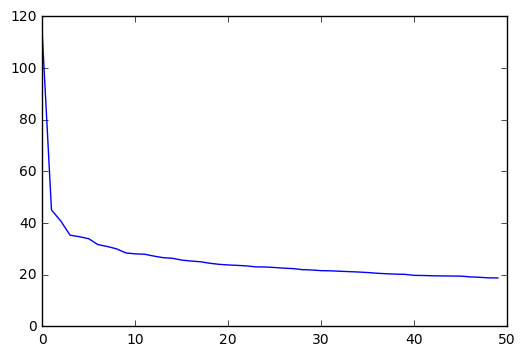

In [53]:
plt.plot(s)

In [56]:
S = np.diagflat(s)

In [57]:
features_matrix = np.dot(U, S)

In [58]:
features_matrix.shape

(187836, 50)

In [59]:
np.save('features_matrix', features_matrix)